<a href="https://colab.research.google.com/github/TAMIDSpiyalong/Machine-Learning-for-Computer-Vision/blob/main/Day4c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mask RCNN Application in Precision Livestock Farming





This lab is based on a TAMIDS project that aims to sense cattle feeding time using MaskRCNN. You can find all the details about this project here [paper](https://www.preprints.org/manuscript/202307.0705/v1). To learn more about the model: https://pytorch.org/vision/main/models/mask_rcnn.html



## Background

Feeding behavior in livestock operations plays a crucial role in determining economic efficiency and ensuring the health and well-being of group-fed animals. Accurate and cost-effective methods for monitoring feeding behavior are essential for optimizing feed costs and detecting health issues. Due to the high cost of equipment and maintenance, many farmer do not have a good way to monitor this data. In this lab, we propose the use Mask RCNN to detect pen-fed beef cattle feeding behavior using cheap cameras and computers.

## Objectives

1. Apply a pre-trained Mask RCNN model on the animal video and generate mask segmentations
2. Define bunk locations and derive feeding time for each bunk accurately
3. Understand the computer vision results

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import cv2
import csv
import json
import pandas as pd
import os
from sklearn.metrics import confusion_matrix,classification_report,precision_score, recall_score,precision_recall_curve,f1_score
from torchvision.io import read_image,read_video
from torchvision.transforms.functional import convert_image_dtype
from torchvision.utils import draw_bounding_boxes,draw_segmentation_masks
from torchvision.models.detection import maskrcnn_resnet50_fpn,maskrcnn_resnet50_fpn_v2 #importing libraries and models


In [2]:
import gdown
gdown.download('https://drive.google.com/uc?export=download&id=11MCdr9MYe-pDgMbV7FvE5wX-5Ei_Ra-L')

# gdown.download('https://drive.google.com/uc?export=download&id=1NwdQljfXfF8CwE4F1X62mmH9x0S9cyYr')

Downloading...
From: https://drive.google.com/uc?export=download&id=11MCdr9MYe-pDgMbV7FvE5wX-5Ei_Ra-L
To: /content/Gallan_Gate_Data.zip
100%|██████████| 198M/198M [00:05<00:00, 38.1MB/s]


'Gallan_Gate_Data.zip'

In [3]:
! unzip -q Gallan_Gate_Data.zip

## Pre-trained Model

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)#checking for and storing gpu

cuda


COCO dataset contains 80 classes, but their class indices are not contiguous, resulting in several "N/A" classes in the list. To address this issue, one approach is to consider the maximum class id, which in this case is 90, resulting in a total of 91 classes. In class of interest is `cow` which is number 21.

This approach simplifies the code as there is no need to maintain a class mapping, similar to what torchvision also does. By using the maximum class id, the code becomes more straightforward and eliminates the need for additional complexities present in maskrcnn-benchmark or detectron2.

In [115]:
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]


In [116]:
CLASSES[21]

'cow'

In [117]:
len(CLASSES)

91

In [118]:
model = maskrcnn_resnet50_fpn_v2(pretrained=True) #defining the model based on pretrained values
model.to(device)
model = model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_V2_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [119]:
inst_class_to_idx = {cls: idx for (idx, cls) in enumerate(CLASSES)}

## Feeding Bunk Definition

With a fix camera, the feed bunk shape can be marked using population annotation tools such as VGG annotator (https://www.robots.ox.ac.uk/~vgg/software/via/via_demo.html). The experiment is carried out at a feedlot station located at Beef Cattle Systems from Texas A&M University, College Station, TX. These animals are kept there for multiple study purposes and there is a physical sensor to record the feeding.


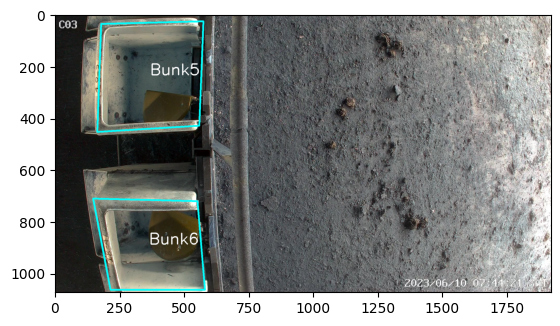

In [120]:
fig, ax = plt.subplots()        #sample image visualization to check model

img = cv2.imread("cg_image.jpg")   # reading image
studyzones='callan_gates_json.json'       #reading json for bunk data

pixelzones = {}

with open(studyzones, 'r') as json_file:    #storing bunks data
    zones = json.load(json_file)
    for each in (zones['shapes']):
        pixelzones.update({each['label']:each['points']})

for zonename,check_zone in pixelzones.items():   #annotating bunks in image and drawing bunk lines
    pts = np.array(check_zone, np.int32)

    p1,p2 = (pts[0],pts[2])
    im=cv2.putText(img,zonename,tuple((np.array([int(x) for x in p1])+np.array([int(x) for x in p2]))//2),cv2.FONT_HERSHEY_SIMPLEX,2, (255,255,255), 3)

    pts = pts.reshape((-1, 1, 2))
    im=cv2.polylines(img,[pts],True,(0,255,255),5)

plt.imshow(im)            #displaying images

The green pixel study zone will be compared to Mask RCNN output for each animal. You can check the variable `pixelzones` is actually a list of point representing the polygon. Now both feeding lots are empty.

## Extract Frames from the Video

Colab does not work well with cv2 imshow, video play and others so we extract frames from the video first. The following code extract 1 frame per second and save them in a folder named `output`. You can see the images in your file explorer. Use CV2_show in stead of cv2.imshow() in colab to avoid crashes.

In [121]:
import cv2
from google.colab.patches import cv2_imshow
import os

In [122]:
file_path="/content/NVRCH04-095511-100011.mp4"
output_folder="output"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

cap = cv2.VideoCapture(file_path)

fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
interval = fps  # Save one frame every second (adjust if needed)



count = 0
frame_number = 0
while count < frame_count:
    ret, frame = cap.read()
    if count % interval == 0:
        frame_filename = f"{output_folder}/frame_{frame_number}.jpg"
        cv2.imwrite(frame_filename, frame)
        frame_number += 1
    count += 1

cap.release()

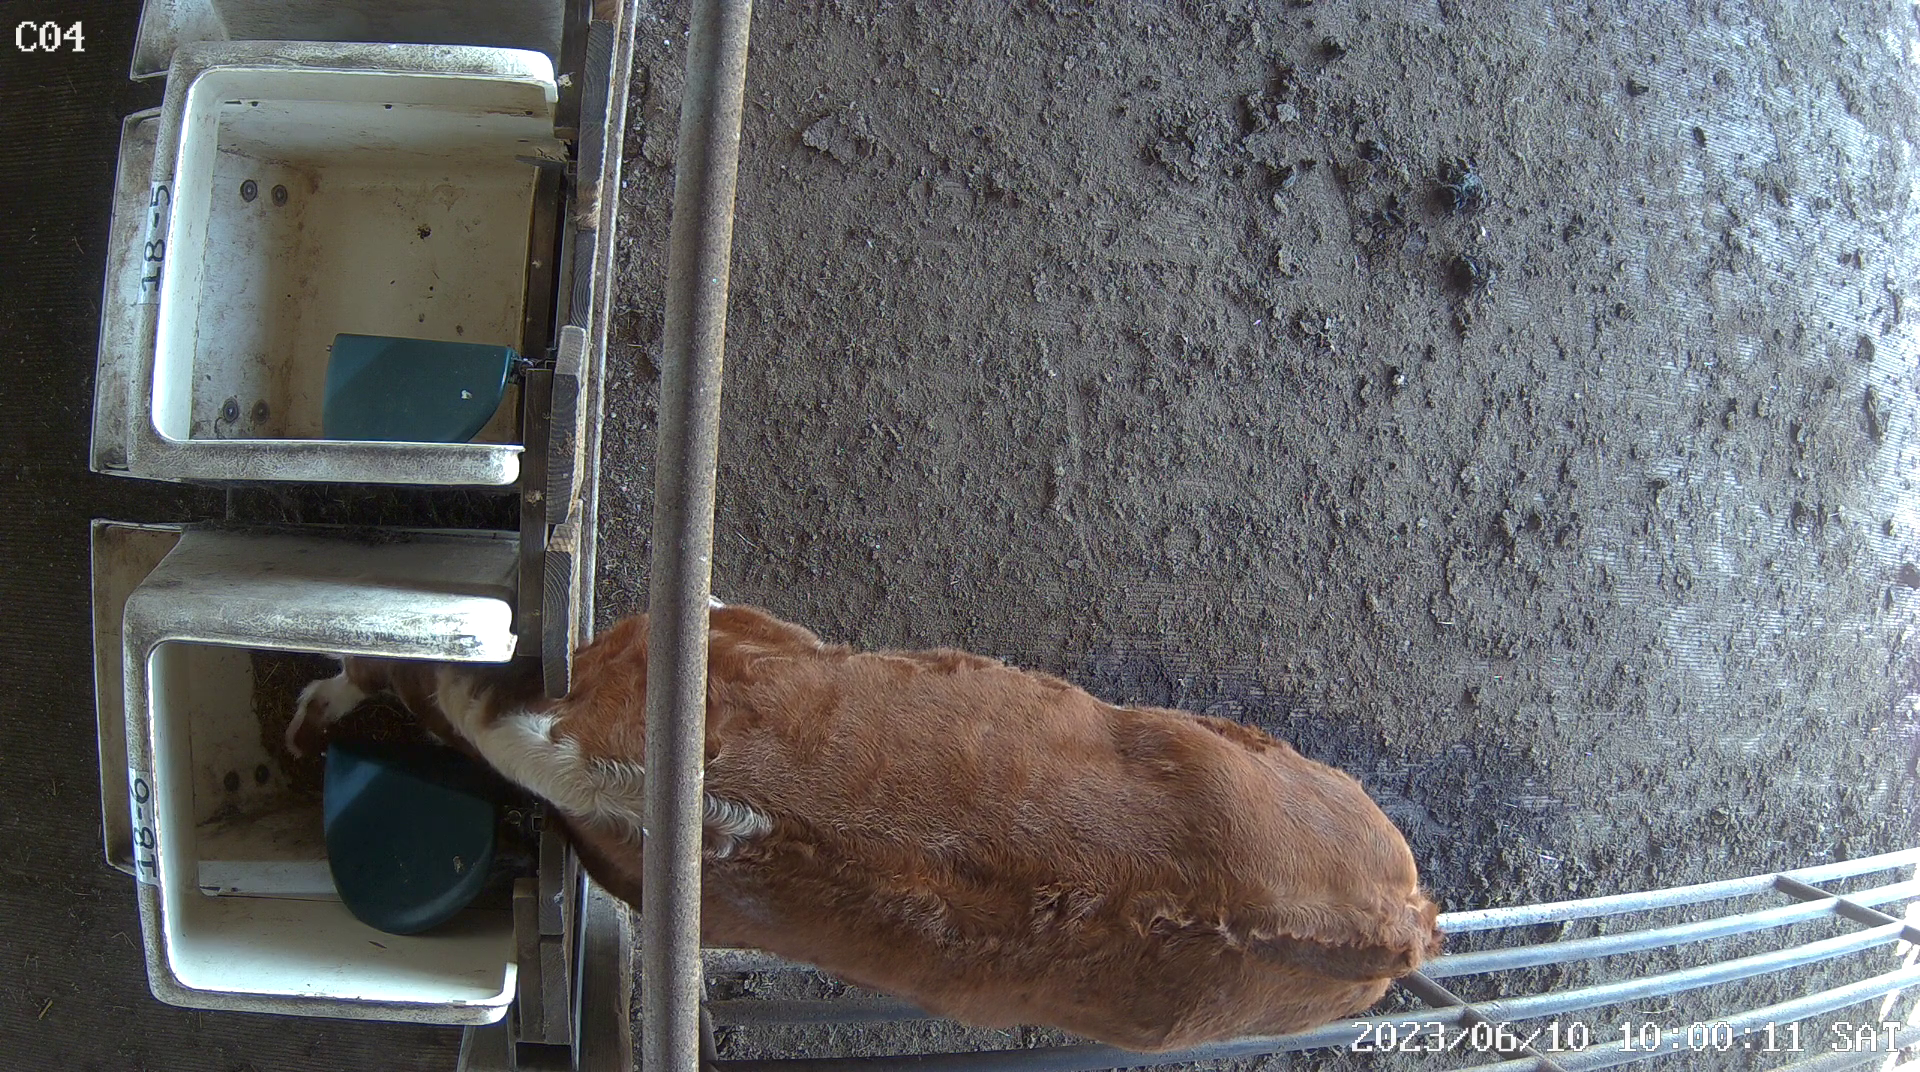

In [123]:
cv2_imshow(frame)

## Make Mask prediction

OpenCV (cv2) is a popular library for computer vision and image processing tasks in Python and other programming languages.

However, OpenCV loads images in BGR format requiring extra handling for RGB, it may lead to bugs, PyTorch's modelzoo is dependent on RGB, and OpenCV has issues with Python's multiprocessing.

In [124]:
from PIL import Image
from torchvision import datasets, models, transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the image to the required input size of your model
    transforms.ToTensor(),          # Convert the image to a PyTorch tensor
    # transforms.Normalize(           # Normalize the image pixel values (if needed)
    #     mean=[0.485, 0.456, 0.406],
    #     std=[0.229, 0.224, 0.225]
    # )
])
image_path='/content/output/frame_146.jpg'
# Load the image using PIL
image = Image.open(image_path)

# Apply the transformation to preprocess the image
preprocessed_image = transform(image).unsqueeze(0).to(device)

In [125]:
preprocessed_image.shape

torch.Size([1, 3, 224, 224])

Sometimes pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225] (COCO statistics).

Sometimes the model does it for you. Print out the model and see the first tranformation layer does it in MaskRCNN. If you normalize twice, the results will not be good. Pay attention and test this yourself.

In [40]:
output = model(preprocessed_image)                           # for gpu

In [133]:
output[0]['masks'].shape

torch.Size([11, 1, 224, 224])

In [134]:
output[0]['boxes'].shape

torch.Size([11, 4])

In [135]:
output[0]['scores']

tensor([0.8738, 0.6254, 0.2818, 0.2382, 0.1698, 0.1230, 0.1088, 0.1044, 0.1019,
        0.0631, 0.0611], device='cuda:0', grad_fn=<IndexBackward0>)

In [136]:
output[0]['labels']

tensor([21, 79, 79, 82, 60, 18, 62, 82, 70, 79, 47], device='cuda:0')

The model generates a list of outputs, corresponding to the input images in the batch. Since there is one image in this batch, the list contains a single element. Each element in the list comprises four keys: "labels" indicating the predicted class, "scores" representing the corresponding probabilities, "boxes" containing the prediction bounding boxes, and "masks" containing binary masks for each instance.

The number of masks in the "masks" key matches the number of box predictions, as they represent the segmentation masks for each detected instance. The masks are one-dimensional arrays, where each array corresponds to one instance's segmentation mask. Each mask has the binary classification probability to mask out the obejct.

## RCNN Structure

Mask RCNN uses the same box detector as Faster RCNN, which is the `box_predictor` below. Somehow it is named FastRCNN. On top of the box, the mask detector is a fully connected network that autocode the pixel classification. The input of both tasks is the feature map filtered by the Rigion of Interest (RoI) network. RoI already applis NMS to select limited high quality regions. More details here https://colab.research.google.com/github/d2l-ai/d2l-en-colab/blob/master/chapter_computer-vision/rcnn.ipynb#scrollTo=d89f015a.

In [144]:
model.roi_heads.box_predictor

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=91, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=364, bias=True)
)

In [114]:
model.roi_heads.mask_predictor

MaskRCNNPredictor(
  (conv5_mask): ConvTranspose2d(256, 256, kernel_size=(2, 2), stride=(2, 2))
  (relu): ReLU(inplace=True)
  (mask_fcn_logits): Conv2d(256, 91, kernel_size=(1, 1), stride=(1, 1))
)

## Understand the Output

In Mask R-CNN, the score_threshold is used to filter the bounding boxes generated by the object detection component based on their confidence scores, while the proba_threshold is utilized to filter the segmentation masks generated by the instance segmentation component based on their pixel probabilities.

Lowering these thresholds (e.g., to 0.1) can include weaker or less accurate detections, increasing recall but potentially reducing precision. On the other hand, raising the thresholds will retain high-confidence detections, leading to a more conservative output with higher precision but possibly lower recall.

 The selection of these thresholds depends on the specific application and dataset to achieve the desired balance between precision and recall in the model's predictions.

In [21]:
score_threshold = 0.1               # box threshold of 0.1 is selected for box generation
proba_threshold = 0.5               # mask threshold of 0.7 is selected for mask generation

 # index of boxes with probability greater than box threshold with label 21(cow)
index = torch.logical_and(output[0]['labels'].detach().cpu() == 21, output[0]['scores'].detach().cpu() > score_threshold)

masks = output[0]['masks'][index].detach().cpu() > proba_threshold

# storing information of masks with probability better than mask threshold
masks = masks.numpy()

The next step involves converting the prediction Tensors into NumPy arrays. By utilizing the numpy package, various computations can be performed effortlessly, as demonstrated in the upcoming example.

In [145]:
masks.shape

(1, 1, 224, 224)

We need to transfer the output mask to show it.

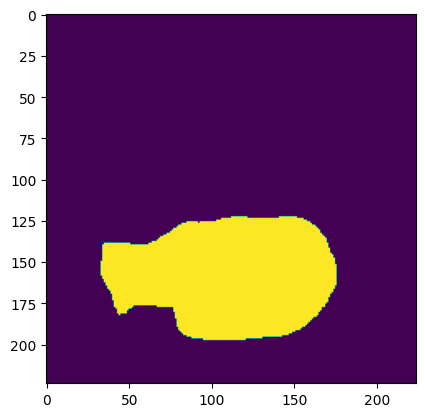

In [146]:
masks[0].shape
image_array = np.transpose(masks[0], (1, 2, 0))
plt.imshow(image_array)

In [147]:
CLASSES[21]

'cow'

## Compare Output Mask and Feed Bunks

We also need to resize the annotated feed bunk to the match shape to do the comparison. This method is also how we calculate the classification error when we train Mask RCNN. Similar to boxes, pixel level IoU is used.

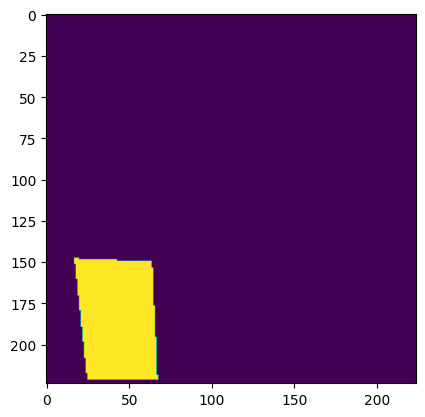

In [148]:
from skimage.transform import resize

for zonename,check_zone in pixelzones.items():
    pts = np.array(check_zone, np.int32)    #Put text and polygon lines
    p1,p2,p3,p4 = pts
    ptss = pts.reshape((-1, 1, 2))
    bunk_mask =  np.zeros((image.height,image.width))
    bunk_mask = cv2.fillPoly(bunk_mask, np.array([pts]).astype("int"), 1) # Build a mask for each bunk
     # Resize the binary mask using the skimage.transform.resize function
    resized_mask = resize(bunk_mask, (224,224), mode='constant', anti_aliasing=False)

    # Binarize the resized mask to ensure it contains only 0s and 1s
    resized_mask[resized_mask >= 0.5] = 1
    resized_mask[resized_mask < 0.5] = 0
    plt.imshow(resized_mask)

For the purpose of this lab, the comparison is easy. We add up the two binary mask matrix and find how many pixels overlap. This overlap is a good indication that the cattle is feeding by extending into the feeding bunk. Could the animal be smelling instead of eating? Totally possible. To solve this we need to work more.

In [149]:
compare_matrix = resized_mask + masks[0]

In [150]:
unique_values, counts = np.unique(compare_matrix, return_counts=True)

# Create a dictionary to store the counts for each unique number
counts_dict = dict(zip(unique_values, counts))

In [151]:
counts_dict

{0.0: 39548, 1.0: 9806, 2.0: 822}

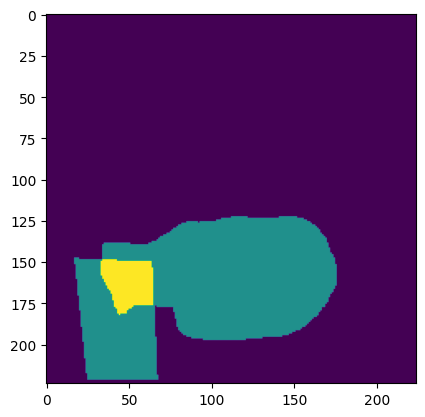

In [152]:
plt.imshow(compare_matrix[0])

## Make It a Function

Check each video frame and return 1 if there is feeding and 0 if there is none.

In [153]:
def check_feeding(image_path):

    # Load the image using PIL
    image = Image.open(image_path)

    # Apply the transformation to preprocess the image
    preprocessed_image = transform(image).unsqueeze(0).to(device)
    output = model(preprocessed_image)                           # for gpu

    score_threshold = 0.5               # box threshold of 0.1 is selected for box generation
    proba_threshold = 0.5               # mask threshold of 0.7 is selected for mask generation

    # index of boxes with probability greater than box threshold with label 21(cow)
    index = torch.logical_and(output[0]['labels'].detach().cpu() == 21, output[0]['scores'].detach().cpu() > score_threshold)

    masks = output[0]['masks'][index].detach().cpu() > proba_threshold

    # storing information of masks with probability better than mask threshold
    masks = masks.numpy()

    results={zonename:0 for zonename,check_zone in pixelzones.items() }

    for zonename,check_zone in pixelzones.items():
        pts = np.array(check_zone, np.int32)    #Put text and polygon lines
        p1,p2,p3,p4 = pts
        ptss = pts.reshape((-1, 1, 2))
        bunk_mask =  np.zeros((image.height,image.width))
        bunk_mask = cv2.fillPoly(bunk_mask, np.array([pts]).astype("int"), 1) # Build a mask for each bunk
        # Resize the binary mask using the skimage.transform.resize function
        resized_mask = resize(bunk_mask, (224,224), mode='constant', anti_aliasing=False)

        # Binarize the resized mask to ensure it contains only 0s and 1s
        resized_mask[resized_mask >= 0.5] = 1
        resized_mask[resized_mask < 0.5] = 0
        for mask in masks:
            compare_matrix = resized_mask+mask[0]
            # plt.imshow(compare_matrix)
            unique_values, counts = np.unique(compare_matrix, return_counts=True)

            # Create a dictionary to store the counts for each unique number
            counts_dict = dict(zip(unique_values, counts))

            if 2 in counts_dict.keys():
                results [zonename]=1
            else:
                results [zonename]=0
    return results

In [154]:
check_feeding(image_path)

{'Bunk5': 0, 'Bunk6': 1}

## Process All Frames

In [ ]:
feed_data_bunk5=[]
feed_data_bunk6=[]

for filename in os.listdir(output_folder):
    file_path = os.path.join(output_folder, filename)
    if os.path.isfile(file_path):
        print(file_path)
        second = file_path[file_path.find('frame_')+6:file_path.find('.jpg')]
        t=int(second)
        feed_data_bunk5.append([t,check_feeding(file_path)['Bunk5']])
        feed_data_bunk6.append([t,check_feeding(file_path)['Bunk6']])


## Plot the Results

We can aggreate the count so we can see when the animal is feeding at a interval of 10 seconds. This is flexible depending on how accurate for farming management requires.

In [155]:
def aggregate_flags(frame_flags, window_size):
    num_segments = len(frame_flags) // window_size
    aggregated_flags = [np.sum(frame_flags[i*window_size:(i+1)*window_size]) for i in range(num_segments)]
    return aggregated_flags

In [156]:
sorted_list = sorted(feed_data_bunk6, key=lambda x: x[0])

print(sorted_list)

[[0, 0], [1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0], [7, 0], [8, 0], [9, 0], [10, 0], [11, 0], [12, 0], [13, 1], [14, 0], [15, 0], [16, 1], [17, 1], [18, 1], [19, 1], [20, 1], [21, 1], [22, 1], [23, 1], [24, 0], [25, 1], [26, 1], [27, 1], [28, 1], [29, 1], [30, 1], [31, 1], [32, 1], [33, 1], [34, 1], [35, 1], [36, 1], [37, 1], [38, 1], [39, 1], [40, 1], [41, 1], [42, 1], [43, 1], [44, 1], [45, 1], [46, 1], [47, 1], [48, 1], [49, 1], [50, 1], [51, 1], [52, 1], [53, 1], [54, 1], [55, 1], [56, 1], [57, 1], [58, 1], [59, 1], [60, 1], [61, 1], [62, 1], [63, 1], [64, 1], [65, 1], [66, 1], [67, 1], [68, 1], [69, 1], [70, 1], [71, 1], [72, 1], [73, 1], [74, 1], [75, 1], [76, 1], [77, 1], [78, 1], [79, 1], [80, 1], [81, 1], [82, 1], [83, 1], [84, 1], [85, 1], [86, 1], [87, 1], [88, 1], [89, 1], [90, 1], [91, 1], [92, 1], [93, 1], [94, 1], [95, 1], [96, 1], [97, 1], [98, 1], [99, 1], [100, 1], [101, 1], [102, 1], [103, 1], [104, 1], [105, 1], [106, 1], [107, 1], [108, 1], [109, 1], [110, 1],

Text(0.5, 1.0, 'Bunk6')

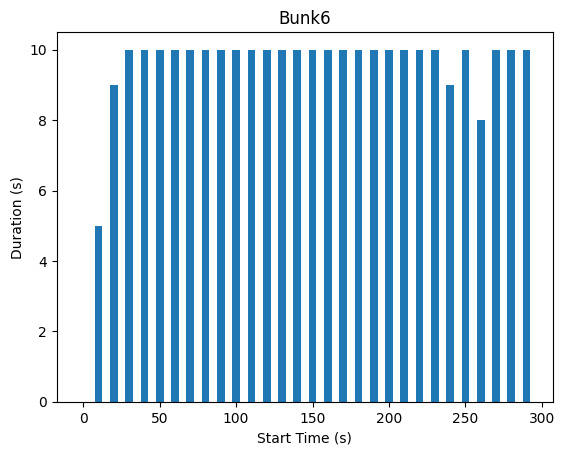

In [157]:
feed_flags=[item[1] for item in sorted_list]
flags=aggregate_flags(feed_flags,10)
x_axis=range(0,len(flags)*10,10)
plt.xlabel('Start Time (s)')
plt.ylabel('Duration (s)')
plt.bar(x_axis,flags,width=5)
plt.title('Bunk6')

In [158]:
sorted_list = sorted(feed_data_bunk5, key=lambda x: x[0])

print(sorted_list)

[[0, 0], [1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0], [7, 0], [8, 0], [9, 0], [10, 0], [11, 0], [12, 0], [13, 0], [14, 0], [15, 0], [16, 0], [17, 0], [18, 0], [19, 0], [20, 0], [21, 0], [22, 0], [23, 0], [24, 0], [25, 0], [26, 0], [27, 0], [28, 0], [29, 0], [30, 0], [31, 0], [32, 0], [33, 0], [34, 0], [35, 0], [36, 0], [37, 0], [38, 0], [39, 0], [40, 0], [41, 0], [42, 0], [43, 0], [44, 0], [45, 0], [46, 0], [47, 0], [48, 0], [49, 0], [50, 0], [51, 0], [52, 0], [53, 0], [54, 0], [55, 0], [56, 0], [57, 0], [58, 0], [59, 0], [60, 0], [61, 0], [62, 0], [63, 0], [64, 0], [65, 0], [66, 0], [67, 0], [68, 0], [69, 0], [70, 0], [71, 0], [72, 0], [73, 0], [74, 0], [75, 0], [76, 0], [77, 0], [78, 0], [79, 0], [80, 0], [81, 0], [82, 0], [83, 0], [84, 0], [85, 0], [86, 0], [87, 0], [88, 0], [89, 0], [90, 0], [91, 0], [92, 0], [93, 0], [94, 0], [95, 0], [96, 0], [97, 0], [98, 0], [99, 0], [100, 0], [101, 0], [102, 0], [103, 0], [104, 0], [105, 0], [106, 0], [107, 0], [108, 0], [109, 0], [110, 0],

Text(0.5, 1.0, 'Bunk5')

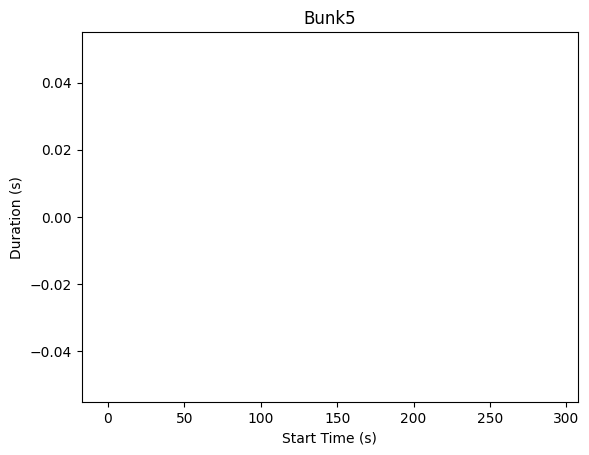

In [159]:
feed_flags=[item[1] for item in sorted_list]
flags=aggregate_flags(feed_flags,10)
x_axis=range(0,len(flags)*10,10)
plt.xlabel('Start Time (s)')
plt.ylabel('Duration (s)')
plt.bar(x_axis,flags,width=5)
plt.title('Bunk5')

## Discussion

If we look at the flags list for bunk 6, we can see in the first 10 seconds there is not feeding. At second 10 there is a person putting feed in the bunk and one yellow animal comes and feeds until the end. However the model misses a few frame toward the end. Bunk 5 does not have much going on, i.e., all 0 for the entire video.

## Conclustion

 This lab demonstrated the application of a pre-trained Mask RCNN model for cattle feeding behavior detection using cheap camera setups. While it achieved promising results, some minor inaccuracies could be further addressed to improve. Overall, the approach showed potential for cost-effective and efficient monitoring of feeding behavior in livestock operations.